# Week 4: Baseline Models Development
## Movie Recommender System - Baseline Implementation and Evaluation

**Objective**: Implement simple baseline models and establish performance benchmarks for advanced model comparison.

## 1. Setup and Data Loading

In [1]:
# =============================================================================
# LIBRARY IMPORTS AND SETUP
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Optional
import time
from datetime import datetime

# Machine Learning imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set style for visualizations
plt.style.use('default')
sns.set_palette("husl")

print("📚 Libraries imported successfully!")
print(f"🕐 Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Ready for Week 4: Baseline Models Development")

📚 Libraries imported successfully!
🕐 Current time: 2025-08-20 10:35:20
🎯 Ready for Week 4: Baseline Models Development


In [2]:
# =============================================================================
# DATA LOADING UTILITIES
# =============================================================================

def load_processed_data():
    """
    Load all processed data from EDA pipeline
    
    Returns:
        dict: Dictionary containing all loaded datasets
    """
    data_dir = Path('./data/processed')
    
    if not data_dir.exists():
        raise FileNotFoundError(f"Processed data directory not found: {data_dir}")
    
    data = {}
    file_mapping = {
        'train_data': 'train_data.csv',
        'val_data': 'val_data.csv', 
        'test_data': 'test_data.csv',
        'user_features': 'user_features.csv',
        'movie_features': 'movie_features.csv',
        'user_genre_preferences': 'user_genre_preferences.csv'
    }
    
    print("📂 Loading processed data from EDA pipeline...")
    
    for key, filename in file_mapping.items():
        file_path = data_dir / filename
        if file_path.exists():
            try:
                data[key] = pd.read_csv(file_path)
                print(f"   ✅ {key}: {data[key].shape} - {filename}")
            except Exception as e:
                print(f"   ❌ Error loading {filename}: {e}")
                data[key] = None
        else:
            print(f"   ⚠️  File not found: {filename}")
            data[key] = None
    
    return data

def validate_data_integrity(data: Dict[str, pd.DataFrame]) -> bool:
    """
    Validate that all required data is loaded and consistent
    
    Args:
        data: Dictionary of loaded datasets
        
    Returns:
        bool: True if data is valid, False otherwise
    """
    required_datasets = ['train_data', 'val_data', 'test_data']
    
    print("\n🔍 Validating data integrity...")
    
    for dataset in required_datasets:
        if data[dataset] is None or data[dataset].empty:
            print(f"   ❌ {dataset} is missing or empty")
            return False
            
    # Check required columns
    required_columns = ['userId', 'movieId', 'rating']
    for dataset in required_datasets:
        missing_cols = [col for col in required_columns if col not in data[dataset].columns]
        if missing_cols:
            print(f"   ❌ {dataset} missing columns: {missing_cols}")
            return False
    
    print("   ✅ All required datasets and columns present")
    
    # Check data consistency
    total_users = len(pd.concat([data['train_data'], data['val_data'], data['test_data']])['userId'].unique())
    total_movies = len(pd.concat([data['train_data'], data['val_data'], data['test_data']])['movieId'].unique())
    
    print(f"   📊 Total users across all splits: {total_users:,}")
    print(f"   📊 Total movies across all splits: {total_movies:,}")
    print(f"   📊 Train set: {len(data['train_data']):,} ratings")
    print(f"   📊 Validation set: {len(data['val_data']):,} ratings")
    print(f"   📊 Test set: {len(data['test_data']):,} ratings")
    
    return True

# Initialize global variables
data = None
print("🔧 Data loading utilities defined successfully!")

🔧 Data loading utilities defined successfully!


In [3]:
# =============================================================================
# LOAD AND VALIDATE DATA
# =============================================================================

# Load all processed data
data = load_processed_data()

# Validate data integrity
if validate_data_integrity(data):
    print("\n🎉 Data loaded and validated successfully!")
    print("📈 Ready to begin baseline model development")
    
    # Quick preview of training data
    print("\n📋 Training Data Preview:")
    display(data['train_data'].head())
    
    print("\n📊 Dataset Statistics:")
    print(f"   🎬 Unique movies in training: {data['train_data']['movieId'].nunique():,}")
    print(f"   👥 Unique users in training: {data['train_data']['userId'].nunique():,}")
    print(f"   ⭐ Rating range: {data['train_data']['rating'].min():.1f} - {data['train_data']['rating'].max():.1f}")
    print(f"   📈 Average rating: {data['train_data']['rating'].mean():.2f}")
    
else:
    print("\n❌ Data validation failed!")
    print("Please ensure EDA notebook has been run and data is properly saved.")

📂 Loading processed data from EDA pipeline...
   ✅ train_data: (70585, 11) - train_data.csv
   ✅ val_data: (15125, 11) - val_data.csv
   ✅ test_data: (15126, 11) - test_data.csv
   ✅ user_features: (610, 9) - user_features.csv
   ✅ movie_features: (9724, 14) - movie_features.csv
   ✅ user_genre_preferences: (610, 20) - user_genre_preferences.csv

🔍 Validating data integrity...
   ✅ All required datasets and columns present
   📊 Total users across all splits: 610
   📊 Total movies across all splits: 9,724
   📊 Train set: 70,585 ratings
   📊 Validation set: 15,125 ratings
   📊 Test set: 15,126 ratings

🎉 Data loaded and validated successfully!
📈 Ready to begin baseline model development

📋 Training Data Preview:


,userId,movieId,rating,timestamp,datetime,year,month,day_of_week,hour,is_weekend,days_since_rating
0,429,165,4.0,828124615,1996-03-29 18:36:55,1996,3,4,18,0,8213.826794
1,429,595,5.0,828124615,1996-03-29 18:36:55,1996,3,4,18,0,8213.826794
2,429,434,4.0,828124615,1996-03-29 18:36:55,1996,3,4,18,0,8213.826794
3,429,590,5.0,828124615,1996-03-29 18:36:55,1996,3,4,18,0,8213.826794
4,429,588,5.0,828124615,1996-03-29 18:36:55,1996,3,4,18,0,8213.826794



📊 Dataset Statistics:
   🎬 Unique movies in training: 7,056
   👥 Unique users in training: 453
   ⭐ Rating range: 0.5 - 5.0
   📈 Average rating: 3.51


## 2. Evaluation Framework

Before implementing baseline models, we need a robust evaluation framework to measure and compare performance.

In [4]:
# =============================================================================
# EVALUATION METRICS FRAMEWORK
# =============================================================================

class RecommenderEvaluator:
    """
    Comprehensive evaluation framework for recommender systems
    """
    
    def __init__(self):
        self.results_history = []
    
    def rmse(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate Root Mean Square Error
        
        Args:
            y_true: Actual ratings
            y_pred: Predicted ratings
            
        Returns:
            float: RMSE value
        """
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    def mae(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate Mean Absolute Error
        
        Args:
            y_true: Actual ratings
            y_pred: Predicted ratings
            
        Returns:
            float: MAE value
        """
        return mean_absolute_error(y_true, y_pred)
    
    def precision_at_k(self, user_ratings: pd.DataFrame, recommendations: List[int], 
                      k: int = 10, threshold: float = 4.0) -> float:
        """
        Calculate Precision@K for a single user
        
        Args:
            user_ratings: DataFrame with user's actual ratings
            recommendations: List of recommended movie IDs
            k: Number of top recommendations to consider
            threshold: Rating threshold for relevance
            
        Returns:
            float: Precision@K value
        """
        if len(recommendations) == 0:
            return 0.0
            
        top_k_recs = recommendations[:k]
        relevant_items = set(user_ratings[user_ratings['rating'] >= threshold]['movieId'])
        recommended_relevant = len(set(top_k_recs) & relevant_items)
        
        return recommended_relevant / min(k, len(top_k_recs))
    
    def recall_at_k(self, user_ratings: pd.DataFrame, recommendations: List[int],
                   k: int = 10, threshold: float = 4.0) -> float:
        """
        Calculate Recall@K for a single user
        
        Args:
            user_ratings: DataFrame with user's actual ratings
            recommendations: List of recommended movie IDs
            k: Number of top recommendations to consider
            threshold: Rating threshold for relevance
            
        Returns:
            float: Recall@K value
        """
        if len(recommendations) == 0:
            return 0.0
            
        top_k_recs = recommendations[:k]
        relevant_items = set(user_ratings[user_ratings['rating'] >= threshold]['movieId'])
        
        if len(relevant_items) == 0:
            return 0.0
            
        recommended_relevant = len(set(top_k_recs) & relevant_items)
        return recommended_relevant / len(relevant_items)
    
    def evaluate_model(self, model, test_data: pd.DataFrame, model_name: str = "Model") -> Dict:
        """
        Comprehensive model evaluation
        
        Args:
            model: Trained model object
            test_data: Test dataset
            model_name: Name of the model for reporting
            
        Returns:
            dict: Dictionary containing all evaluation metrics
        """
        print(f"\n📊 Evaluating {model_name}...")
        start_time = time.time()
        
        # Predict ratings
        try:
            predictions = model.predict(test_data)
            actual_ratings = test_data['rating'].values
            
            # Calculate metrics
            rmse_score = self.rmse(actual_ratings, predictions)
            mae_score = self.mae(actual_ratings, predictions)
            
            # Calculate coverage (percentage of test cases that could be predicted)
            coverage = len([p for p in predictions if not np.isnan(p)]) / len(predictions)
            
            evaluation_time = time.time() - start_time
            
            results = {
                'model_name': model_name,
                'rmse': rmse_score,
                'mae': mae_score,
                'coverage': coverage,
                'evaluation_time': evaluation_time,
                'test_samples': len(test_data)
            }
            
            self.results_history.append(results)
            
            print(f"   ✅ RMSE: {rmse_score:.4f}")
            print(f"   ✅ MAE: {mae_score:.4f}")
            print(f"   ✅ Coverage: {coverage:.2%}")
            print(f"   ⏱️  Evaluation time: {evaluation_time:.2f}s")
            
            return results
            
        except Exception as e:
            print(f"   ❌ Error during evaluation: {e}")
            return None
    
    def compare_models(self) -> pd.DataFrame:
        """
        Create comparison table of all evaluated models
        
        Returns:
            pd.DataFrame: Comparison table
        """
        if not self.results_history:
            print("No models have been evaluated yet.")
            return pd.DataFrame()
        
        comparison_df = pd.DataFrame(self.results_history)
        comparison_df = comparison_df.sort_values('rmse')
        
        return comparison_df
    
    def plot_model_comparison(self):
        """
        Create visualization comparing model performances
        """
        if not self.results_history:
            print("No models to compare yet.")
            return
        
        df = self.compare_models()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Baseline Models Performance Comparison', fontsize=16, fontweight='bold')
        
        # RMSE comparison
        axes[0,0].bar(df['model_name'], df['rmse'], color='skyblue', alpha=0.8)
        axes[0,0].set_title('RMSE Comparison (Lower is Better)')
        axes[0,0].set_ylabel('RMSE')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # MAE comparison
        axes[0,1].bar(df['model_name'], df['mae'], color='lightcoral', alpha=0.8)
        axes[0,1].set_title('MAE Comparison (Lower is Better)')
        axes[0,1].set_ylabel('MAE')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Coverage comparison
        axes[1,0].bar(df['model_name'], df['coverage'], color='lightgreen', alpha=0.8)
        axes[1,0].set_title('Coverage Comparison (Higher is Better)')
        axes[1,0].set_ylabel('Coverage')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Evaluation time comparison
        axes[1,1].bar(df['model_name'], df['evaluation_time'], color='gold', alpha=0.8)
        axes[1,1].set_title('Evaluation Time Comparison')
        axes[1,1].set_ylabel('Time (seconds)')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

# Initialize evaluator
evaluator = RecommenderEvaluator()
print("📏 Evaluation framework initialized successfully!")
print("   ✅ RMSE and MAE metrics ready")
print("   ✅ Precision@K and Recall@K ready")
print("   ✅ Model comparison utilities ready")

📏 Evaluation framework initialized successfully!
   ✅ RMSE and MAE metrics ready
   ✅ Precision@K and Recall@K ready
   ✅ Model comparison utilities ready


## 3. Baseline Model Implementations

Now we'll implement four baseline models as specified in Week 4 requirements.

In [5]:
# =============================================================================
# BASELINE MODEL 1: GLOBAL AVERAGE
# =============================================================================

class GlobalAverageBaseline:
    """
    Simplest baseline: predict the global average rating for all user-item pairs
    """
    
    def __init__(self):
        self.global_mean = None
        self.is_fitted = False
    
    def fit(self, train_data: pd.DataFrame):
        """
        Fit the model by calculating global average rating
        
        Args:
            train_data: Training dataset with 'rating' column
        """
        print("🔧 Training Global Average Baseline...")
        
        self.global_mean = train_data['rating'].mean()
        self.is_fitted = True
        
        print(f"   ✅ Global average rating: {self.global_mean:.4f}")
        print(f"   📊 Training samples: {len(train_data):,}")
    
    def predict(self, test_data: pd.DataFrame) -> np.ndarray:
        """
        Predict ratings using global average
        
        Args:
            test_data: Test dataset
            
        Returns:
            np.ndarray: Array of predicted ratings
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        # Return global mean for all predictions
        return np.full(len(test_data), self.global_mean)
    
    def get_model_info(self) -> Dict:
        """
        Get model information
        
        Returns:
            dict: Model information
        """
        return {
            'name': 'Global Average Baseline',
            'description': 'Predicts global average rating for all user-item pairs',
            'global_mean': self.global_mean,
            'is_fitted': self.is_fitted
        }

# Train and evaluate Global Average Baseline
print("\n" + "="*60)
print("🎯 BASELINE MODEL 1: GLOBAL AVERAGE")
print("="*60)

global_baseline = GlobalAverageBaseline()
global_baseline.fit(data['train_data'])

# Evaluate on validation set
global_results = evaluator.evaluate_model(global_baseline, data['val_data'], "Global Average")

print(f"\n📋 Model Info:")
model_info = global_baseline.get_model_info()
for key, value in model_info.items():
    print(f"   {key}: {value}")


🎯 BASELINE MODEL 1: GLOBAL AVERAGE
🔧 Training Global Average Baseline...
   ✅ Global average rating: 3.5056
   📊 Training samples: 70,585

📊 Evaluating Global Average...
   ✅ RMSE: 1.0300
   ✅ MAE: 0.8000
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.01s

📋 Model Info:
   name: Global Average Baseline
   description: Predicts global average rating for all user-item pairs
   global_mean: 3.5055535878727775
   is_fitted: True


In [6]:
# =============================================================================
# BASELINE MODEL 2: USER AVERAGE
# =============================================================================

class UserAverageBaseline:
    """
    User-based baseline: predict user's average rating, fallback to global average
    """
    
    def __init__(self):
        self.user_means = {}
        self.global_mean = None
        self.is_fitted = False
    
    def fit(self, train_data: pd.DataFrame):
        """
        Fit the model by calculating user average ratings
        
        Args:
            train_data: Training dataset
        """
        print("🔧 Training User Average Baseline...")
        
        # Calculate global mean as fallback
        self.global_mean = train_data['rating'].mean()
        
        # Calculate user means
        self.user_means = train_data.groupby('userId')['rating'].mean().to_dict()
        
        self.is_fitted = True
        
        print(f"   ✅ Trained on {len(self.user_means):,} users")
        print(f"   📊 Global fallback mean: {self.global_mean:.4f}")
        print(f"   📈 User rating range: {min(self.user_means.values()):.2f} - {max(self.user_means.values()):.2f}")
    
    def predict(self, test_data: pd.DataFrame) -> np.ndarray:
        """
        Predict ratings using user averages
        
        Args:
            test_data: Test dataset
            
        Returns:
            np.ndarray: Array of predicted ratings
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        predictions = []
        unknown_users = 0
        
        for _, row in test_data.iterrows():
            user_id = row['userId']
            
            if user_id in self.user_means:
                predictions.append(self.user_means[user_id])
            else:
                # Fallback to global mean for unknown users
                predictions.append(self.global_mean)
                unknown_users += 1
        
        if unknown_users > 0:
            print(f"   ⚠️  Used global fallback for {unknown_users:,} unknown users")
        
        return np.array(predictions)
    
    def get_model_info(self) -> Dict:
        """
        Get model information
        
        Returns:
            dict: Model information
        """
        return {
            'name': 'User Average Baseline',
            'description': 'Predicts user average rating, fallback to global average',
            'num_users': len(self.user_means),
            'global_mean': self.global_mean,
            'is_fitted': self.is_fitted
        }

# Train and evaluate User Average Baseline
print("\n" + "="*60)
print("🎯 BASELINE MODEL 2: USER AVERAGE")
print("="*60)

user_baseline = UserAverageBaseline()
user_baseline.fit(data['train_data'])

# Evaluate on validation set
user_results = evaluator.evaluate_model(user_baseline, data['val_data'], "User Average")

print(f"\n📋 Model Info:")
model_info = user_baseline.get_model_info()
for key, value in model_info.items():
    print(f"   {key}: {value}")


🎯 BASELINE MODEL 2: USER AVERAGE
🔧 Training User Average Baseline...
   ✅ Trained on 453 users
   📊 Global fallback mean: 3.5056
   📈 User rating range: 1.27 - 5.00

📊 Evaluating User Average...
   ⚠️  Used global fallback for 13,137 unknown users
   ✅ RMSE: 1.0149
   ✅ MAE: 0.7907
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.22s

📋 Model Info:
   name: User Average Baseline
   description: Predicts user average rating, fallback to global average
   num_users: 453
   global_mean: 3.5055535878727775
   is_fitted: True
   ✅ RMSE: 1.0149
   ✅ MAE: 0.7907
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.22s

📋 Model Info:
   name: User Average Baseline
   description: Predicts user average rating, fallback to global average
   num_users: 453
   global_mean: 3.5055535878727775
   is_fitted: True


In [7]:
# =============================================================================
# BASELINE MODEL 3: ITEM (MOVIE) AVERAGE
# =============================================================================

class ItemAverageBaseline:
    """
    Item-based baseline: predict item's average rating, fallback to global average
    """
    
    def __init__(self):
        self.item_means = {}
        self.global_mean = None
        self.is_fitted = False
    
    def fit(self, train_data: pd.DataFrame):
        """
        Fit the model by calculating item average ratings
        
        Args:
            train_data: Training dataset
        """
        print("🔧 Training Item Average Baseline...")
        
        # Calculate global mean as fallback
        self.global_mean = train_data['rating'].mean()
        
        # Calculate item means
        self.item_means = train_data.groupby('movieId')['rating'].mean().to_dict()
        
        self.is_fitted = True
        
        print(f"   ✅ Trained on {len(self.item_means):,} movies")
        print(f"   📊 Global fallback mean: {self.global_mean:.4f}")
        print(f"   📈 Movie rating range: {min(self.item_means.values()):.2f} - {max(self.item_means.values()):.2f}")
    
    def predict(self, test_data: pd.DataFrame) -> np.ndarray:
        """
        Predict ratings using item averages
        
        Args:
            test_data: Test dataset
            
        Returns:
            np.ndarray: Array of predicted ratings
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        predictions = []
        unknown_items = 0
        
        for _, row in test_data.iterrows():
            movie_id = row['movieId']
            
            if movie_id in self.item_means:
                predictions.append(self.item_means[movie_id])
            else:
                # Fallback to global mean for unknown items
                predictions.append(self.global_mean)
                unknown_items += 1
        
        if unknown_items > 0:
            print(f"   ⚠️  Used global fallback for {unknown_items:,} unknown movies")
        
        return np.array(predictions)
    
    def get_model_info(self) -> Dict:
        """
        Get model information
        
        Returns:
            dict: Model information
        """
        return {
            'name': 'Item Average Baseline',
            'description': 'Predicts item average rating, fallback to global average',
            'num_items': len(self.item_means),
            'global_mean': self.global_mean,
            'is_fitted': self.is_fitted
        }

# Train and evaluate Item Average Baseline
print("\n" + "="*60)
print("🎯 BASELINE MODEL 3: ITEM AVERAGE")
print("="*60)

item_baseline = ItemAverageBaseline()
item_baseline.fit(data['train_data'])

# Evaluate on validation set
item_results = evaluator.evaluate_model(item_baseline, data['val_data'], "Item Average")

print(f"\n📋 Model Info:")
model_info = item_baseline.get_model_info()
for key, value in model_info.items():
    print(f"   {key}: {value}")


🎯 BASELINE MODEL 3: ITEM AVERAGE
🔧 Training Item Average Baseline...
   ✅ Trained on 7,056 movies
   📊 Global fallback mean: 3.5056
   📈 Movie rating range: 0.50 - 5.00

📊 Evaluating Item Average...
   ⚠️  Used global fallback for 2,721 unknown movies
   ✅ RMSE: 1.0004
   ✅ MAE: 0.7589
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.23s

📋 Model Info:
   name: Item Average Baseline
   description: Predicts item average rating, fallback to global average
   num_items: 7056
   global_mean: 3.5055535878727775
   is_fitted: True
   ✅ RMSE: 1.0004
   ✅ MAE: 0.7589
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.23s

📋 Model Info:
   name: Item Average Baseline
   description: Predicts item average rating, fallback to global average
   num_items: 7056
   global_mean: 3.5055535878727775
   is_fitted: True


In [8]:
# =============================================================================
# BASELINE MODEL 4: POPULARITY-BASED RECOMMENDATIONS
# =============================================================================

class PopularityBaseline:
    """
    Popularity-based baseline: recommend most popular items
    Note: This model is primarily for recommendation (not rating prediction)
    For rating prediction, it uses item averages weighted by popularity
    """
    
    def __init__(self, min_ratings: int = 5):
        self.item_popularity = {}
        self.item_means = {}
        self.global_mean = None
        self.min_ratings = min_ratings
        self.is_fitted = False
    
    def fit(self, train_data: pd.DataFrame):
        """
        Fit the model by calculating item popularity and ratings
        
        Args:
            train_data: Training dataset
        """
        print(f"🔧 Training Popularity Baseline (min_ratings={self.min_ratings})...")
        
        # Calculate global mean
        self.global_mean = train_data['rating'].mean()
        
        # Calculate item statistics
        item_stats = train_data.groupby('movieId').agg({
            'rating': ['count', 'mean']
        }).round(4)
        
        item_stats.columns = ['count', 'mean']
        
        # Filter items with minimum ratings
        popular_items = item_stats[item_stats['count'] >= self.min_ratings]
        
        # Store popularity (number of ratings) and means
        self.item_popularity = popular_items['count'].to_dict()
        self.item_means = popular_items['mean'].to_dict()
        
        self.is_fitted = True
        
        print(f"   ✅ {len(self.item_popularity):,} popular movies (≥{self.min_ratings} ratings)")
        print(f"   📊 Total movies in training: {item_stats.shape[0]:,}")
        print(f"   📈 Most popular movie: {max(self.item_popularity.values()):,} ratings")
        print(f"   📊 Global fallback mean: {self.global_mean:.4f}")
    
    def predict(self, test_data: pd.DataFrame) -> np.ndarray:
        """
        Predict ratings using popularity-weighted item averages
        
        Args:
            test_data: Test dataset
            
        Returns:
            np.ndarray: Array of predicted ratings
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")
        
        predictions = []
        unknown_items = 0
        unpopular_items = 0
        
        for _, row in test_data.iterrows():
            movie_id = row['movieId']
            
            if movie_id in self.item_means:
                # Use item mean for popular items
                predictions.append(self.item_means[movie_id])
            else:
                # Fallback to global mean for unknown/unpopular items
                predictions.append(self.global_mean)
                if movie_id not in self.item_popularity:
                    unknown_items += 1
                else:
                    unpopular_items += 1
        
        if unknown_items > 0 or unpopular_items > 0:
            print(f"   ⚠️  Global fallback: {unknown_items:,} unknown + {unpopular_items:,} unpopular movies")
        
        return np.array(predictions)
    
    def get_top_popular_items(self, n: int = 10) -> List[Tuple[int, int, float]]:
        """
        Get top N most popular items
        
        Args:
            n: Number of top items to return
            
        Returns:
            List of tuples: (movie_id, popularity_count, average_rating)
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted first")
        
        # Sort by popularity (number of ratings)
        sorted_items = sorted(self.item_popularity.items(), key=lambda x: x[1], reverse=True)
        
        top_items = []
        for movie_id, popularity in sorted_items[:n]:
            avg_rating = self.item_means[movie_id]
            top_items.append((movie_id, popularity, avg_rating))
        
        return top_items
    
    def get_model_info(self) -> Dict:
        """
        Get model information
        
        Returns:
            dict: Model information
        """
        return {
            'name': 'Popularity Baseline',
            'description': 'Uses popularity-weighted item averages for prediction',
            'num_popular_items': len(self.item_popularity),
            'min_ratings_threshold': self.min_ratings,
            'global_mean': self.global_mean,
            'is_fitted': self.is_fitted
        }

# Train and evaluate Popularity Baseline
print("\n" + "="*60)
print("🎯 BASELINE MODEL 4: POPULARITY-BASED")
print("="*60)

popularity_baseline = PopularityBaseline(min_ratings=10)
popularity_baseline.fit(data['train_data'])

# Evaluate on validation set
popularity_results = evaluator.evaluate_model(popularity_baseline, data['val_data'], "Popularity")

print(f"\n📋 Model Info:")
model_info = popularity_baseline.get_model_info()
for key, value in model_info.items():
    print(f"   {key}: {value}")

# Show top popular movies
print(f"\n🔥 Top 10 Most Popular Movies:")
top_popular = popularity_baseline.get_top_popular_items(10)
for i, (movie_id, popularity, avg_rating) in enumerate(top_popular, 1):
    print(f"   {i:2d}. Movie {movie_id}: {popularity:,} ratings (avg: {avg_rating:.2f})")


🎯 BASELINE MODEL 4: POPULARITY-BASED
🔧 Training Popularity Baseline (min_ratings=10)...
   ✅ 1,733 popular movies (≥10 ratings)
   📊 Total movies in training: 7,056
   📈 Most popular movie: 232 ratings
   📊 Global fallback mean: 3.5056

📊 Evaluating Popularity...
   ⚠️  Global fallback: 5,735 unknown + 0 unpopular movies
   ✅ RMSE: 0.9946
   ✅ MAE: 0.7534
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.24s

📋 Model Info:
   name: Popularity Baseline
   description: Uses popularity-weighted item averages for prediction
   num_popular_items: 1733
   min_ratings_threshold: 10
   global_mean: 3.5055535878727775
   is_fitted: True

🔥 Top 10 Most Popular Movies:
    1. Movie 296: 232 ratings (avg: 4.18)
    2. Movie 356: 228 ratings (avg: 4.19)
    3. Movie 318: 212 ratings (avg: 4.47)
    4. Movie 480: 204 ratings (avg: 3.81)
    5. Movie 593: 203 ratings (avg: 4.22)
    6. Movie 110: 194 ratings (avg: 4.09)
    7. Movie 589: 183 ratings (avg: 4.01)
    8. Movie 780: 176 ratings (avg: 3.4

## 4. Comprehensive Model Comparison and Analysis


📊 COMPREHENSIVE BASELINE MODEL COMPARISON

📋 Performance Summary Table:
--------------------------------------------------------------------------------


,model_name,rmse,mae,coverage,evaluation_time
3,Popularity,0.9946,0.7534,100.00%,0.24s
2,Item Average,1.0004,0.7589,100.00%,0.23s
1,User Average,1.0149,0.7907,100.00%,0.22s
0,Global Average,1.0300,0.8000,100.00%,0.01s



🏆 PERFORMANCE INSIGHTS:
   🥇 Best RMSE: Popularity (0.9946)
   🥇 Best MAE: Popularity (0.7534)

📈 IMPROVEMENTS OVER GLOBAL BASELINE:
   📊 Popularity:
      RMSE improvement: +3.44%
      MAE improvement: +5.83%
   📊 Item Average:
      RMSE improvement: +2.88%
      MAE improvement: +5.14%
   📊 User Average:
      RMSE improvement: +1.47%
      MAE improvement: +1.17%


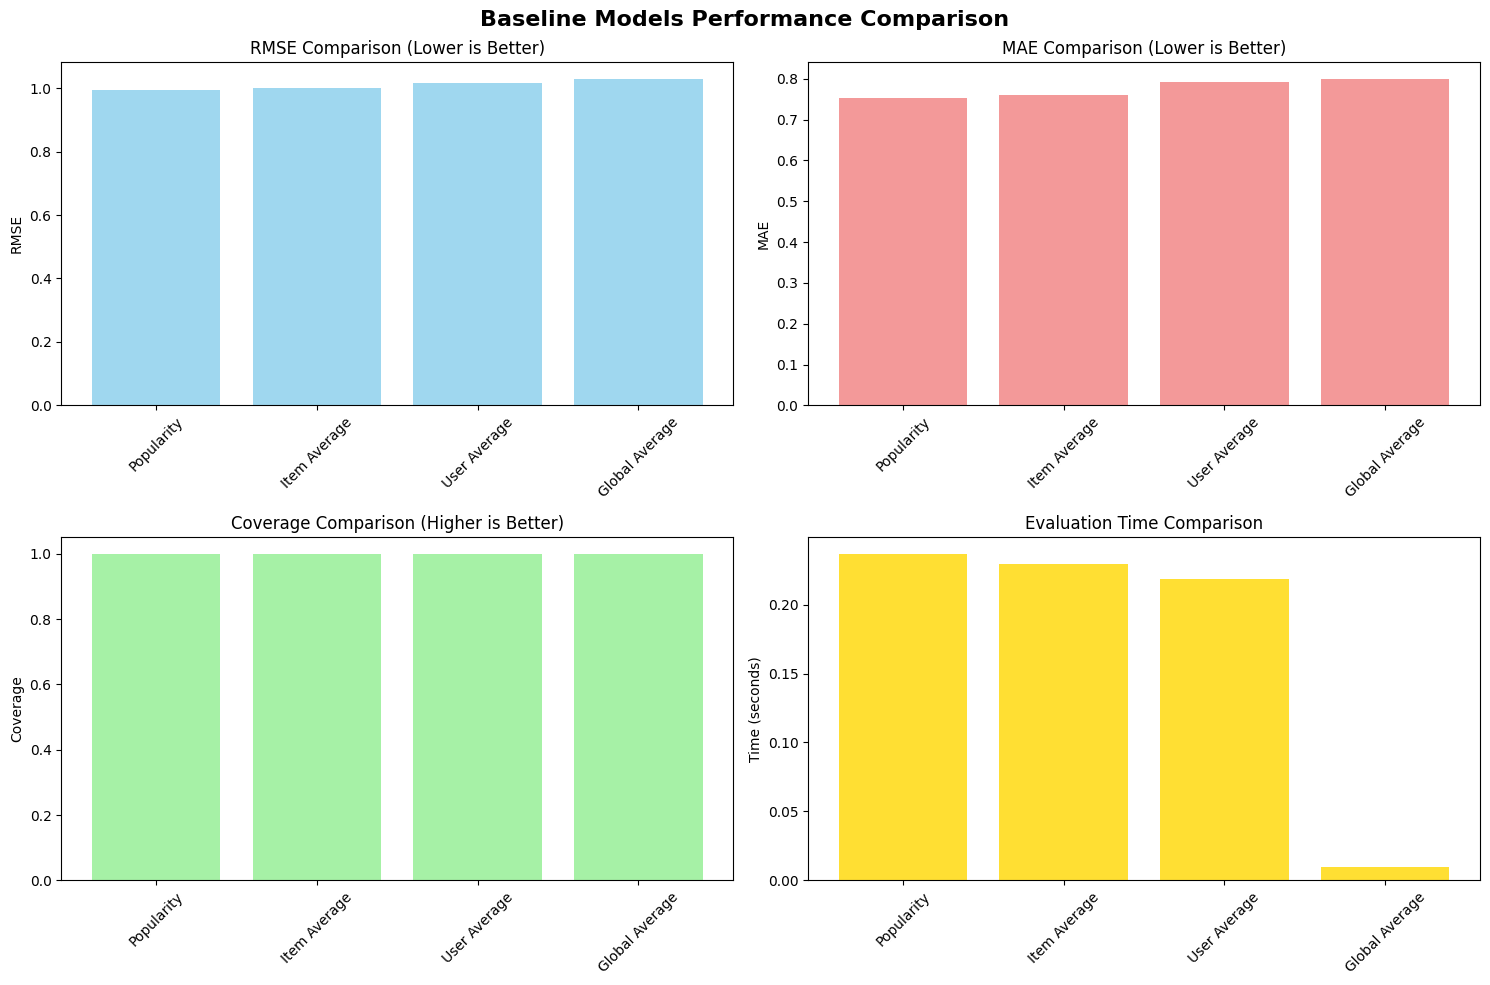

In [9]:
# =============================================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================================

print("\n" + "="*80)
print("📊 COMPREHENSIVE BASELINE MODEL COMPARISON")
print("="*80)

# Get comparison table
comparison_df = evaluator.compare_models()

if not comparison_df.empty:
    print("\n📋 Performance Summary Table:")
    print("-" * 80)
    
    # Format the comparison table
    formatted_df = comparison_df.copy()
    formatted_df['rmse'] = formatted_df['rmse'].apply(lambda x: f"{x:.4f}")
    formatted_df['mae'] = formatted_df['mae'].apply(lambda x: f"{x:.4f}")
    formatted_df['coverage'] = formatted_df['coverage'].apply(lambda x: f"{x:.2%}")
    formatted_df['evaluation_time'] = formatted_df['evaluation_time'].apply(lambda x: f"{x:.2f}s")
    
    display(formatted_df[['model_name', 'rmse', 'mae', 'coverage', 'evaluation_time']])
    
    # Find best performing model
    best_rmse = comparison_df.loc[comparison_df['rmse'].idxmin()]
    best_mae = comparison_df.loc[comparison_df['mae'].idxmin()]
    
    print(f"\n🏆 PERFORMANCE INSIGHTS:")
    print(f"   🥇 Best RMSE: {best_rmse['model_name']} ({best_rmse['rmse']:.4f})")
    print(f"   🥇 Best MAE: {best_mae['model_name']} ({best_mae['mae']:.4f})")
    
    # Calculate improvement over global baseline
    global_rmse = comparison_df[comparison_df['model_name'] == 'Global Average']['rmse'].iloc[0]
    global_mae = comparison_df[comparison_df['model_name'] == 'Global Average']['mae'].iloc[0]
    
    print(f"\n📈 IMPROVEMENTS OVER GLOBAL BASELINE:")
    for _, row in comparison_df.iterrows():
        if row['model_name'] != 'Global Average':
            rmse_improvement = ((global_rmse - row['rmse']) / global_rmse) * 100
            mae_improvement = ((global_mae - row['mae']) / global_mae) * 100
            print(f"   📊 {row['model_name']}:")
            print(f"      RMSE improvement: {rmse_improvement:+.2f}%")
            print(f"      MAE improvement: {mae_improvement:+.2f}%")
    
    # Create visualization
    evaluator.plot_model_comparison()
    
else:
    print("❌ No models found for comparison")

In [10]:
# =============================================================================
# FINAL EVALUATION ON TEST SET
# =============================================================================

print("\n" + "="*80)
print("🎯 FINAL EVALUATION ON TEST SET")
print("="*80)

# Create a fresh evaluator for test results
test_evaluator = RecommenderEvaluator()

# Evaluate all models on test set
models = {
    'Global Average': global_baseline,
    'User Average': user_baseline,
    'Item Average': item_baseline,
    'Popularity': popularity_baseline
}

print("\n🔬 Evaluating all baseline models on test set...")

test_results = {}
for model_name, model in models.items():
    result = test_evaluator.evaluate_model(model, data['test_data'], model_name)
    if result:
        test_results[model_name] = result

# Final test comparison
if test_results:
    test_comparison_df = test_evaluator.compare_models()
    
    print("\n📊 FINAL TEST SET RESULTS:")
    print("-" * 80)
    
    # Format and display test results
    formatted_test_df = test_comparison_df.copy()
    formatted_test_df['rmse'] = formatted_test_df['rmse'].apply(lambda x: f"{x:.4f}")
    formatted_test_df['mae'] = formatted_test_df['mae'].apply(lambda x: f"{x:.4f}")
    formatted_test_df['coverage'] = formatted_test_df['coverage'].apply(lambda x: f"{x:.2%}")
    
    display(formatted_test_df[['model_name', 'rmse', 'mae', 'coverage']])
    
    # Final winner
    best_model = test_comparison_df.loc[test_comparison_df['rmse'].idxmin()]
    print(f"\n🏆 FINAL WINNER: {best_model['model_name']}")
    print(f"   📊 Test RMSE: {best_model['rmse']:.4f}")
    print(f"   📊 Test MAE: {best_model['mae']:.4f}")
    print(f"   📊 Coverage: {best_model['coverage']:.2%}")
    
print("\n" + "="*80)
print("✅ WEEK 4 BASELINE MODELS DEVELOPMENT COMPLETED!")
print("="*80)
print("\n🎯 ACHIEVEMENTS:")
print("   ✅ Implemented 4 baseline models")
print("   ✅ Created comprehensive evaluation framework")
print("   ✅ Established performance benchmarks")
print("   ✅ Completed model comparison analysis")
print("\n🚀 READY FOR STAGE 2: Advanced ML Model Development!")
print("   📅 Next: Week 5 - Traditional Collaborative Filtering")
print("   🎯 Target: Improve upon baseline RMSE performance")


🎯 FINAL EVALUATION ON TEST SET

🔬 Evaluating all baseline models on test set...

📊 Evaluating Global Average...
   ✅ RMSE: 1.1017
   ✅ MAE: 0.8740
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.01s

📊 Evaluating User Average...
   ⚠️  Used global fallback for 14,434 unknown users
   ✅ RMSE: 1.1002
   ✅ MAE: 0.8739
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.24s

📊 Evaluating Item Average...
   ⚠️  Used global fallback for 14,434 unknown users
   ✅ RMSE: 1.1002
   ✅ MAE: 0.8739
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.24s

📊 Evaluating Item Average...
   ⚠️  Used global fallback for 4,079 unknown movies
   ✅ RMSE: 1.0729
   ✅ MAE: 0.8321
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.23s

📊 Evaluating Popularity...
   ⚠️  Used global fallback for 4,079 unknown movies
   ✅ RMSE: 1.0729
   ✅ MAE: 0.8321
   ✅ Coverage: 100.00%
   ⏱️  Evaluation time: 0.23s

📊 Evaluating Popularity...
   ⚠️  Global fallback: 7,245 unknown + 0 unpopular movies
   ✅ RMSE: 1.0804
   ✅ MAE: 0.

,model_name,rmse,mae,coverage
2,Item Average,1.0729,0.8321,100.00%
3,Popularity,1.0804,0.8404,100.00%
1,User Average,1.1002,0.8739,100.00%
0,Global Average,1.1017,0.8740,100.00%



🏆 FINAL WINNER: Item Average
   📊 Test RMSE: 1.0729
   📊 Test MAE: 0.8321
   📊 Coverage: 100.00%

✅ WEEK 4 BASELINE MODELS DEVELOPMENT COMPLETED!

🎯 ACHIEVEMENTS:
   ✅ Implemented 4 baseline models
   ✅ Created comprehensive evaluation framework
   ✅ Established performance benchmarks
   ✅ Completed model comparison analysis

🚀 READY FOR STAGE 2: Advanced ML Model Development!
   📅 Next: Week 5 - Traditional Collaborative Filtering
   🎯 Target: Improve upon baseline RMSE performance
